In [1]:
pip install fsspec

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import relevant modules and the full arxiv dataset
import logging
logger = logging.getLogger("spacy")
logger.setLevel(logging.ERROR)

import dask.bag as db
import json
import pandas as pd
import numpy as np

# docs = db.read_text('arxiv-metadata-oai-snapshot.json').map(json.loads)

In [1]:
# The dataset is very huge. Not sure if the whole set can be used. I start prototyping with a subset of the data so it's easier to handle:
# This procedure was recommended in the ArXiv dataset itself

get_latest_version = lambda x: x['versions'][-1]['created']


# get only necessary fields of the metadata file
trim = lambda x: {'title': x['title'],
                  'category':x['categories'].split(' '),}

# filter for papers published on or after 2021-01-01
columns = ['id','category','abstract']
docs_df = (docs.filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2020)
           .map(trim).
           compute())

NameError: name 'docs' is not defined

In [38]:
# Convert data to pandas DataFrame
docs_df = pd.DataFrame(docs_df)

In [39]:
# Write to csv for faster future access
docs_df.to_csv("trimmed_arxiv_docs.csv", index=False)

In [2]:
# Read csv to retrieve data
df = pd.read_csv("./trimmed_arxiv_docs.csv")

In [32]:
# Find out the number of ml papers in this dataset
n = 0
for i in range(0, len(df['category'])):
    if 'cs.LG' in df['category'][i]:
        n += 1
print('There have been', n, 'papers in Machine learning since 2021')

There have been 37088 papers in Machine learning since 2021


In [381]:
# Create new dataset which contains same number of ml and non ml papers which will be used for training
titles = []
ml_identity = []
n = 0
for i in range(0, len(df['category'])):   
    if 'cs.LG' in df['category'][i]:
        titles.append(df['title'][i])
        ml_identity.append(1)
    elif n < 37088:
        titles.append(df['title'][i])
        ml_identity.append(0)
        n += 1       

dataset = pd.DataFrame({'title': titles, 'label': ml_identity}, columns=['title', 'label'])
dataset.tail()
#print('For example' , titles[0], 'is an ml paper' if ml_identity[0]==1 else 'is not an ml paper')  

,title,label
74171,Universality of empirical risk minimization,1
74172,The Exact Class of Graph Functions Generated b...,1
74173,General Cyclical Training of Neural Networks,1
74174,Data-SUITE: Data-centric identification of in-...,1
74175,Adiabatic Quantum Computing for Multi Object T...,1


In [151]:
# Shuffle the dataset then create a test and training dataset
shuffled_data = dataset.sample(frac = 1)
traindata = shuffled_data.iloc[:37088,:]
testdata = shuffled_data.iloc[37088:,:]

titlestrain = traindata.loc[:,'title']
labelstrain = traindata.loc[:,'label']
titlestest = testdata.loc[:,'title']
labelstest = testdata.loc[:,'label']

In [188]:
# Import tokenizer and calibrate on our data

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(dataset['title'])

In [189]:
# Make every tokenized sequence the same length 

maxlen=50

def get_sequences(tokenizer, titles):
    
    sequences = tokenizer.texts_to_sequences(titles)
    padded = pad_sequences(sequences, truncating = 'post', padding='post', maxlen=maxlen)
    
    return padded

In [191]:
# Can see the numerical form of a title now extended to length 50
padded_titlestrain = get_sequences(tokenizer, titlestrain)
padded_titlestrain[0]

array([  67,  158,   81,  313,    4,  272, 1759,   20,  139,   65,   62,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [428]:
# Define  the classes of the classifier, for now it is just ML or not: 1 and 0

classes = ('Other', 'Machine Learning')
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [201]:
# Create model
import tensorflow as tf

model = tf.keras.Sequential([

tf.keras.layers.Embedding(10000,16,input_length=maxlen),
tf.keras.layers.GlobalAveragePooling1D(),
tf.keras.layers.Dense(16, activation='relu'),
tf.keras.layers.Dense(1),
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [207]:
# Compile model and train
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

# Create a validation data set from the training data set to test the model at each step
valtitles = padded_titlestrain[:10000]
partial_titlestrain = padded_titlestrain[10000:]

vallabels = labelstrain[:10000]
partial_labelstrain = labelstrain[10000:]

history = model.fit(partial_titlestrain,
                    partial_labelstrain,
                    epochs=40,
                    batch_size=512,
                    validation_data=(valtitles, vallabels),
                    verbose=1)

Epoch 1/40
53/53 [==============================] - 1s 5ms/step - loss: 0.6904 - accuracy: 0.5738 - val_loss: 0.6859 - val_accuracy: 0.8075
Epoch 2/40
53/53 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.7875 - val_loss: 0.6579 - val_accuracy: 0.7698
Epoch 3/40
53/53 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.8198 - val_loss: 0.5941 - val_accuracy: 0.8217
Epoch 4/40
53/53 [==============================] - 0s 3ms/step - loss: 0.5451 - accuracy: 0.8394 - val_loss: 0.5097 - val_accuracy: 0.8373
Epoch 5/40
53/53 [==============================] - 0s 3ms/step - loss: 0.4609 - accuracy: 0.8494 - val_loss: 0.4413 - val_accuracy: 0.8434
Epoch 6/40
53/53 [==============================] - 0s 3ms/step - loss: 0.4005 - accuracy: 0.8565 - val_loss: 0.3991 - val_accuracy: 0.8476
Epoch 7/40
53/53 [==============================] - 0s 3ms/step - loss: 0.3605 - accuracy: 0.8674 - val_loss: 0.3724 - val_accuracy: 0.8529
Epoch 8/40
53/53 [==

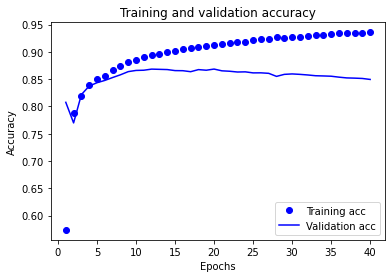

In [212]:
# Plot the training and validation accuracy over the range of epochs
import matplotlib.pyplot as plt

history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Trend due to overfitting, tweak hyperparameters

In [208]:
# Test the model on our test dataset
padded_titlestest = get_sequences(tokenizer, titlestest)

results = model.evaluate(padded_titlestest, labelstest)

1159/1159 [==============================] - 1s 595us/step - loss: 0.3879 - accuracy: 0.8519


As you can see we achieve an accuracy of 85% using a very simple approach to Natural Language Processing. More advanced approaches (Bidirectional layers, etc.) would easily achieve accuracies into the 90's.

In [538]:
# For fun, test the classifier on a specific title to see if it gets it right

i = np.random.randint(0,len(labelstest)-1)
print('Title:', titlestest.iloc[i])
print('Category:', index_to_class[labelstest.iloc[i]])
# print(padded_titlestest[i])
p = model.predict(np.expand_dims(padded_titlestest[i], axis=0))
if p > 0.5:
    p = 1
else:
    p = 0
pred_class=index_to_class[p]
print('Predicted Category: ', pred_class)

Title: Label Contrastive Coding based Graph Neural Network for Graph
  Classification
Category: Machine Learning
Predicted Category:  Machine Learning


An network like this could potentially allow a better analysis of the data involved in the application of machine learning to the physical sciences, as it removes the dependence on third parties to classify the data. Also look at weighting the algorithm.

Sources:
https://medium.com/geekculture/nlp-with-tensorflow-keras-explanation-and-tutorial-cae3554b1290
https://www.tensorflow.org/hub/tutorials/tf2_text_classification
https://towardsdatascience.com/natural-language-processing-with-tensorflow-e0a701ef5cef
https://www.kaggle.com/onyonixch/scientific-paper-clustering